In [9]:
import pandas as pd

# df = pd.read_csv("SongsWithLyricsAndLang.csv", sep=";")
# df.info()
# lyrics_df = df[(df["Language"] == "en") & (df["Language Score"] >= 0.990)]
# lyrics_df.info()
# lyrics_df.to_csv("englishSongsWithLyrics.csv", sep =";", index=False)

lyrics_df = pd.read_csv("englishSongsWithLyrics.csv", sep=";")

In [10]:
# Create a dictionary of all the words appearing in all the English songs, with a count of how many songs each word appears in
import json 
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
  
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
alphabet = "abcdefghijklmnopqrstuvwxyz"

def create_corpus(df, remove_stopwords=False, remove_plurals=False):
    # corpus is the dictionary that will hold the set of words and their counts
    corpus = dict()
    for lyrics in df["Lyrics"]:
        try:
            lines = lyrics.lower().split("\n")
        except AttributeError:
            pass
        else:
            words = set()
            cleaned_words = set()
            for line in lines:
                # Unidecode replaces accented characters with their unaccented equivalent
                line = unidecode(line)                  
                if remove_plurals:
                    line_words_l = pos_tag(line.split())
                    line_words_l = [lemmatizer.lemmatize(word[0], 'n') if word[1]=="NNS" else word[0] for word in line_words_l]
                    line = " ".join(line_words_l)
                words = words.union(set(line.split(" ")))
            while len(words) > 0:
                word = words.pop()
                # Strip punctuation
                while (len(word)>0) and (word[0] not in alphabet):
                    word = word[1:]
                while (len(word)>0) and (word[-1] not in alphabet):
                    word = word[:-1]   
                # If the word is not an empty string after removing punctuation, check if it's in corpus
                # If the word is in corpus, increase its count by 1; if not, add it to corpus with count equal to 1
                if len(word) > 0:
                    if remove_stopwords and (word in stop_words):
                        continue
                    if word not in corpus:
                        corpus[word] = 1
                    if (word in corpus) and (word not in cleaned_words):
                        corpus[word] += 1
                        cleaned_words.add(word)
    return corpus

# with open('full_english_corpus', 'w') as fp:
#     english_corpus = create_corpus(lyrics_df)
#     print(len(english_corpus))
#     json.dump(english_corpus, fp, indent = 4) 

with open('english_corpus_no_plurals.json', 'w') as fp:
    english_corpus = create_corpus(lyrics_df, remove_plurals=True)
    print(len(english_corpus))
    json.dump(english_corpus, fp, indent = 4) 

12873


In [11]:
import numpy as np

genre_list = [
    'Blues',
    'Country',
    'Dance/Electronic',
    'Folk',
    'Hip Hop',
    'Indie Pop',
    'Jazz',
    'Metal',
    'Pop',
    'R&B',
    'Rock'
]

# # Writes the corpus for each genre to a .json file'
# for genre in genre_list:
#     genre_df = lyrics_df[lyrics_df["Genre"] == genre]
#     with open(genre.lower().replace("&", "n").replace("/", "_").replace(" ", "_")+'_corpus.json', 'w') as fp:
#         corpus = create_corpus(genre_df)
#         json.dump(corpus, fp, indent = 4) 


# We used the create_corpus function to generate the dictionary of words and the number of songs they appear in within each genre.
# Here, we add TPR (true positive rate) and FPR (false positive rate) for each word within each genre.
# To calcualate the FPR for a given word and genre, we need the word's TPR within the other genres (for words that aren't in a genre's corpus, the TPR score within that genre is zero).
# We start by adding TPR scores to the corpus dictionaries for each genre and putting the modified dictionaries in a larger dictionary.
corpus_dict = dict()
for genre in genre_list:
    genre_df = lyrics_df[lyrics_df["Genre"] == genre]
    total_songs = len(genre_df)
    corpus = create_corpus(genre_df)
    # name = genre.lower().replace(" ", "_").replace("&", "n").replace("/", "_")
    # with open(name+'_corpus.json', 'r') as json_file:
    #     corpus = json.load(json_file)
    scores_dict = dict()
    for word in corpus:
        scores_dict[word]= {"Song Count": corpus[word], "TPR-FPR":None, "TPR": corpus[word]/total_songs, "FPR": None}
    corpus_dict[genre] = scores_dict

# Now that we have all the TPR scores for each word-genre pair, we can calculate FPR scores for each word-genre pair.
for genre in genre_list:
    other_genres = set(genre_list)-{genre}
    current_corpus = corpus_dict[genre]
    for word in current_corpus:
        other_TPRs = []
        for other_genre in other_genres:
            other_corpus = corpus_dict[other_genre]
            if word in set(other_corpus.keys()).intersection(current_corpus.keys()):
                other_TPRs.append(other_corpus[word]["TPR"])
            else:
                other_TPRs.append(0)
        current_corpus[word]["FPR"] = np.mean(other_TPRs)+np.std(other_TPRs)
        current_corpus[word]["TPR-FPR"] = max(current_corpus[word]["TPR"]-current_corpus[word]["FPR"],0)
    current_corpus = dict(sorted(current_corpus.items(), key=lambda item: item[1]["TPR-FPR"], reverse=True))
    with open(genre.lower().replace("&", "n").replace("/", "_").replace(" ", "_")+'_keywords_no_plurals.json', 'w') as fp:
        json.dump(current_corpus, fp, indent = 4) 



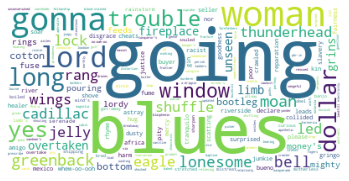

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

with open('blues_keywords.json', 'r') as json_file:
    corpus = json.load(json_file) 
scores = {word: corpus[word]["TPR-FPR"] for word in corpus}
word_cloud = WordCloud(background_color='white')
word_cloud.generate_from_frequencies(frequencies=scores)
# print(word_cloud)
plt.figure()
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


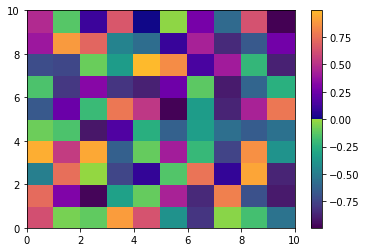

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

data = np.random.rand(10,10) * 2 - 1

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.viridis(np.linspace(0., 0.85, 128))
colors2 = plt.cm.plasma(np.linspace(0., 0.85, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

blues_map = mcolors.LinearSegmentedColormap.from_list("", ["#4200A2","#0D00FF"])
jazz_map = mcolors.LinearSegmentedColormap.from_list("", ["#00B47E","#6900FF"])
folk_map = mcolors.LinearSegmentedColormap.from_list("", ["#EC7D3F","#6865FF"])
country_map = mcolors.LinearSegmentedColormap.from_list("", ["#874400","#FB9E00"])
dance_map = mcolors.LinearSegmentedColormap.from_list("", ["#DB00FF","#00F495"])
indie_map = mcolors.LinearSegmentedColormap.from_list("", ["#2E87FE","#FF7C7C"])
rock_map = mcolors.LinearSegmentedColormap.from_list("", ["#C30006","#FF7300"])
metal_map = mcolors.LinearSegmentedColormap.from_list("", ["#A40005","#5700A4"])
rnb_map = mcolors.LinearSegmentedColormap.from_list("", ["#FF00A1","#6900FF"])
hiphop_map = mcolors.LinearSegmentedColormap.from_list("", ["#9200D6","#FF5400"])
pop_map = mcolors.LinearSegmentedColormap.from_list("", ["#FF00E6","#C686FF"])

plt.pcolor(data, cmap=mymap)
plt.colorbar()
plt.show()

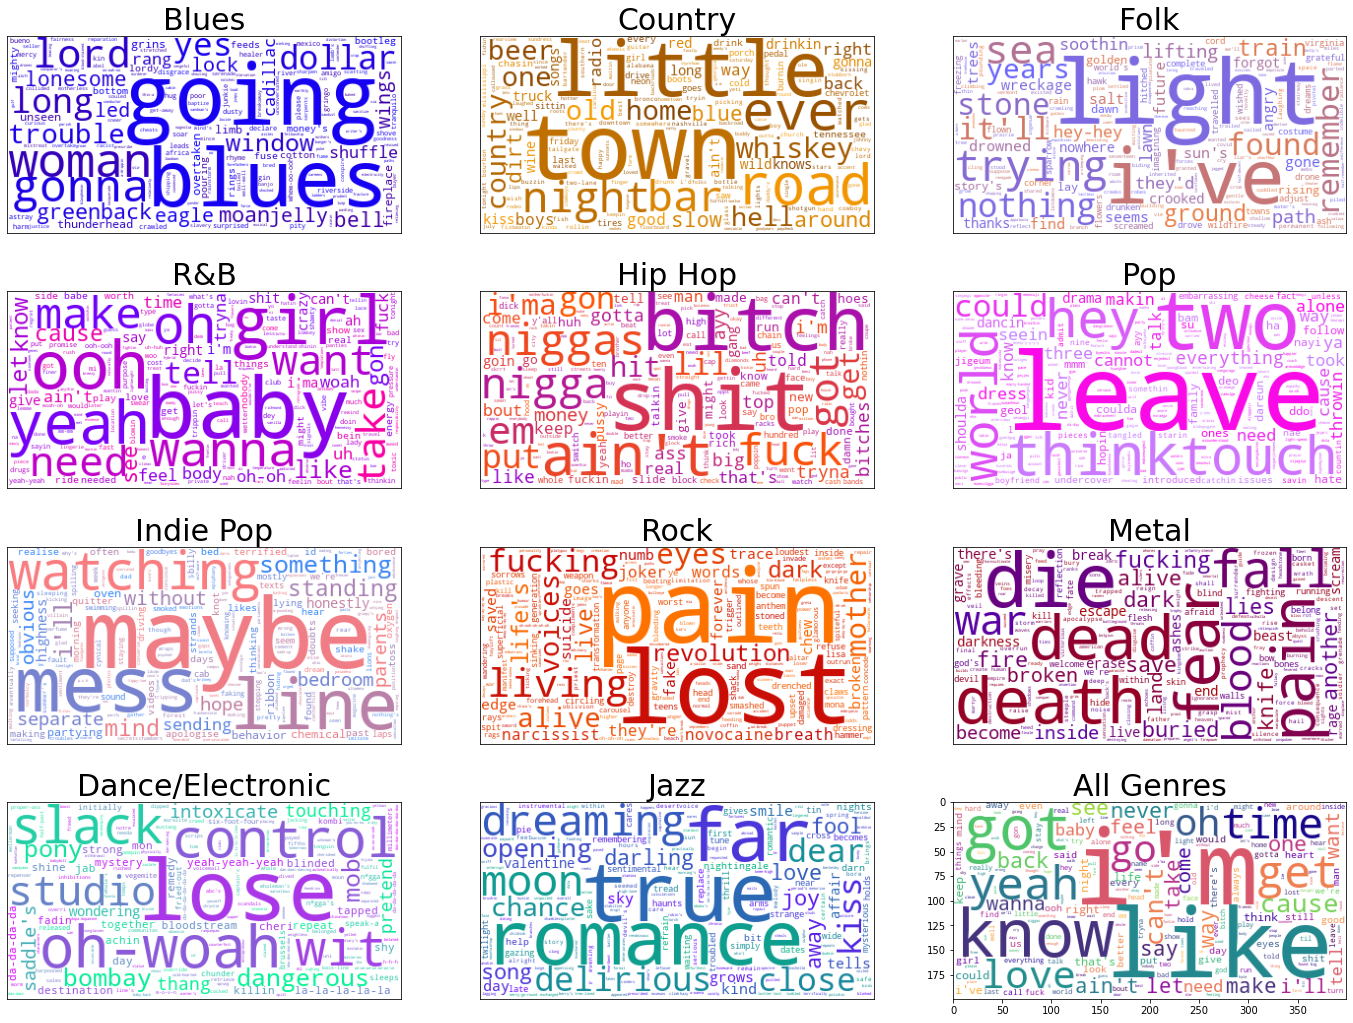

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud

placements = {
    'Blues':(0,0), 
    'Country':(0,1),
    'Folk':(0,2),
    'R&B':(1,0),
    'Hip Hop':(1,1),
    'Pop':(1,2), 
    'Indie Pop':(2,0),
    'Rock':(2,1),
    'Metal':(2,2),
    'Dance/Electronic':(3,0),
    'Jazz':(3,1)
    }    

colors = {
    'Blues': blues_map, 
    'Country': country_map, 
    'Folk': folk_map,
    'R&B':rnb_map,
    'Hip Hop':hiphop_map,
    'Pop':pop_map, 
    'Indie Pop':indie_map,
    'Rock':rock_map,
    'Metal':metal_map,
    'Dance/Electronic':dance_map,
    'Jazz': jazz_map
    }    

wordclouds = [None]*11

fig, axs = plt.subplots(4, 3, figsize=(24, 18))

for genre in genre_list:
    name = genre.lower().replace(" ", "_").replace("&", "n").replace("/", "_")
    with open(name+'_keywords.json', 'r') as json_file:
        corpus = json.load(json_file)      
    scores = {word: corpus[word]["TPR-FPR"] for word in corpus if word not in stop_words}
    i = genre_list.index(genre)
    wordclouds[i] = WordCloud(background_color='white', colormap = colors[genre])
    wordclouds[i].generate_from_frequencies(frequencies=scores)
    
    coords = placements[genre][0], placements[genre][1] 
    axs[coords].set_title(genre, fontsize=30)
    axs[coords].imshow(wordclouds[i])
    
    
    axs[coords].tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,       # ticks along the right edge are off
        left=False,        # ticks along the left edge are off
        labelbottom=False,  # labels along the bottom edge are off  
        labelleft=False)   # labels along the left edge are off  

with open('english_corpus_no_stopwords.json', 'r') as json_file:
    corpus = json.load(json_file) 
all_genre_cloud = WordCloud(background_color='white', colormap = mymap) #colormap = matplotlib.cm.get_cmap(name=gist_rainbow)
all_genre_cloud.generate_from_frequencies(frequencies=corpus)
axs[3,2].set_title("All Genres", fontsize=30)
axs[3,2].imshow(all_genre_cloud)


axs[coords].tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    right=False,       # ticks along the right edge are off
    left=False,        # ticks along the left edge are off
    labelbottom=False,  # labels along the bottom edge are off  
    labelleft=False)   # labels along the left edge are off  

plt.show()